In [49]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

In [50]:
groq_api_key  = os.getenv("GROQ_API_KEY")

## langsmith Tracing
os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "Arithmetic Agent"

In [51]:
llm = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

In [52]:
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Alamin"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Alamin

Yes, I know about whales. But what others should I learn about?


In [53]:
llm.invoke(messages)

AIMessage(content="Whales are indeed fascinating creatures. Besides whales, there are many other interesting ocean mammals to learn about. Here are a few:\n\n1. **Dolphins**: They're closely related to whales, but smaller and more agile. Did you know that dolphins are highly social and have been observed using tools?\n2. **Seals** (also known as **Earless Seals**): These fin-footed, semi-aquatic marine mammals are found in oceans around the world. They're known for their streamlined bodies and ability to dive deep.\n3. **Sea Lions**: Similar to seals, but with external ear flaps. Sea lions are highly intelligent and can walk on land using their flippers.\n4. **Walruses**: Large, tusked mammals that inhabit the Arctic and sub-Arctic oceans. They're known for their distinctive tusks and blubbery bodies.\n5. **Manatees** (also known as **Sea Cows**): Large, slow-moving herbivores found in shallow waters in the Caribbean and Gulf of Mexico. They're related to elephants and are considered e

## Now define a Basics ChatModel with Build in MessagesState

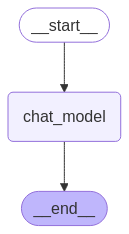

In [54]:
from IPython.display import display, Image
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph

## define the node
def chat_model(state: MessagesState):
    """This is a chat model its interact with the user messages"""
    
    return {
        'messages': llm.invoke(state['messages'])
    }
    
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model)

builder.add_edge(START, 'chat_model')
builder.add_edge("chat_model", END)

my_graph = builder.compile()

# Displaying the graph
display(Image(my_graph.get_graph().draw_mermaid_png()))

In [55]:
response = my_graph.invoke(
    {
        'messages': messages
    }
)

In [56]:
for msg in response['messages']:
    msg.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Alamin

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Whales are indeed fascinating creatures. Besides whales, there are many other interesting ocean mammals to learn about. Here are a few:

1. **Dolphins**: They're closely related to whales, but smaller and more agile. Did you know that dolphins are highly social and have been observed using tools?
2. **Seals** (or **Pinnipeds**): These semi-aquatic mammals have flippers and spend time on land. There are several species, including harbor seals, elephant seals, and monk seals.
3. **Sea Lions**: Similar to seals, but with external ear flaps and the ability to walk on their hind flippers. They're found in the Pacific

## Reducer

See the problem like messages are increasing and increasing so now time to reduce this messages. and its create the problem in long tram conversion

we remove the messages using the reducer

In [57]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for num in a[:-2]:
    print(num)

1
2
3
4
5
6
7


In [58]:
messages

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3697b800-b604-480a-bc42-8d0d09096b16'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Alamin', id='6a5769ba-5dc2-4f12-accc-24b17904469f')]

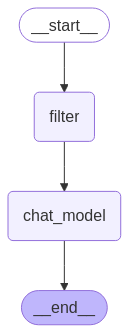

In [59]:
from IPython.display import display, Image
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import RemoveMessage

## define the node
def filter_messages(state:MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][: -2]]
    
    return {
        'messages': delete_messages
    }

def chat_model(state: MessagesState):
    """This is a chat model its interact with the user messages
       And the chat model get only the last two messages
    """
    return {
        'messages': llm.invoke(state['messages'])
    }
    
builder = StateGraph(MessagesState)
builder.add_node('filter', filter_messages)
builder.add_node("chat_model", chat_model)

builder.add_edge(START, 'filter')
builder.add_edge('filter', 'chat_model')
builder.add_edge("chat_model", END)

my_graph = builder.compile()

# Displaying the graph
display(Image(my_graph.get_graph().draw_mermaid_png()))

In [60]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Alamin", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Alamin", id="4"))

# Invoke
output = my_graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Alamin

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Whales are indeed fascinating creatures. Besides whales, there are many other interesting ocean mammals to learn about. Here are a few:

1. **Dolphins**: These intelligent and social creatures are closely related to whales. Did you know that dolphins have their own signature whistles, like human names?
2. **Seals and Sea Lions**: These fin-footed mammals are found in oceans worldwide. They're known for their agility on land and in water. Sea lions are actually a type of seal, but with external ear flaps!
3. **Walruses**: The largest of the pinnipeds (fin-footed mammals), walruses are famous for their tusks and b

# **Filter Messages**
just pass the last messages to the llm `llm.invoke(messages[-1: ])` to the model

In [61]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for num in a[-2:]:
    print(num)

8
9


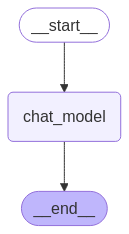

In [62]:
from IPython.display import display, Image
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph

## define the node
def chat_model_node(state: MessagesState):
    """This is a chat model its interact with the user messages"""
    
    return {
        'messages': llm.invoke(state['messages'][-1:])
    }
    
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, 'chat_model')
builder.add_edge("chat_model", END)

my_graph = builder.compile()

# Displaying the graph
display(Image(my_graph.get_graph().draw_mermaid_png()))

In [63]:
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Alamin', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Alamin', id='4')]

In [64]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(content=f"Tell me more about Narwhals!", name="Lance"))
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Alamin', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Alamin', id='4'),
 AIMessage(content="Whales are indeed fascinating creatures. Besides whales, there are many other interesting ocean mammals to learn about. Here are a few:\n\n1. **Dolphins**: These intelligent and social creatures are closely related to whales. Did you know that dolphins have their own signature whistles, like human names?\n2. **Seals and Sea Lions**: These fin-footed mammals are found in oceans worldwide. They're known for their agility on land and in water. Sea lions are actually a type of seal, but with externa

In [65]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Alamin

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Alamin

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Whales are indeed fascinating creatures. Besides whales, there are many other interesting ocean mammals to learn about. Here are a few:

1. **Dolphins**: These intelligent and social creatures are closely related to whales. Did you know that dolphins have their own signature whistles, like human names?
2. **Seals and Sea Lions**: These fin-footed mammals are found in oceans worldwide. They're known for their agility on l

In [66]:
# Invoke, using message filtering
output = my_graph.invoke({'messages': messages})

for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Alamin

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Alamin

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Whales are indeed fascinating creatures. Besides whales, there are many other interesting ocean mammals to learn about. Here are a few:

1. **Dolphins**: These intelligent and social creatures are closely related to whales. Did you know that dolphins have their own signature whistles, like human names?
2. **Seals and Sea Lions**: These fin-footed mammals are found in oceans worldwide. They're known for their agility on l

# **Trim Messages**

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

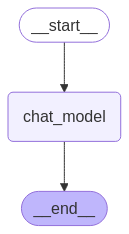

In [67]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Alamin"))

In [ ]:
messages_out_trim = graph.invoke({'messages': messages})